In [2]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b master https://github.com/edsonportosilva/adaptive-signal-processing
    from os import chdir as cd
    cd('/content/notebooks/')
    ! pip install -e .
    ! pip install SciencePlots

import sympy as sp
from sympy import latex
import numpy as np
#from circuit.utils import symdisp, symplot
from IPython.display import Math, Latex, display
import matplotlib.pyplot as plt

In [3]:
from IPython.core.display import HTML
from IPython.display import Image
import scienceplots
from utils import set_preferences, genConvGIF

plt.style.use(['science','ieee'])
set_preferences()

plt.rcParams['figure.figsize'] = [5, 2.5]
plt.rcParams['figure.dpi'] = 150

saveFigures = True
figurePath = 'G:\\Meu Drive\\DEE UFCG\\Disciplinas e ementas\\TEEE - Processamento adaptativo de sinais\\lecture notes\\figures\\'

In [4]:
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    width:200px;
}
</style>
""")

# Introduction to Adaptive Signal Processing

## What is adaptive signal processing?

Adaptive signal processing refers to a set of techniques and algorithms that automatically adjust their parameters in response to changes in the signal or its environment. Unlike traditional signal processing methods that use fixed parameters, adaptive signal processing dynamically updates its parameters to optimize a given performance metric in real-time. 

This adaptability allows it to handle non-stationary signals and varying conditions effectively, making it ideal for several applications such as noise cancellation, equalization, and system identification. 

## Applications

Adaptive signal processing has a wide range of applications across various fields. Some notable examples include:

* **System Identification**: Used to model and understand time-varying systems by adaptively adjusting the system parameters to match the observed input-output behavior, which is crucial in control systems and communications.

* **Equalization**: Applied in digital communication to compensate for signal distortion caused by channel imperfections, ensuring accurate data transmission.

* **Noise Cancellation**: Used in headphones and communication systems to reduce unwanted background noise, improving sound clarity and quality.

* **Echo Cancellation**: Employed in telecommunication systems to eliminate echo effects in phone calls, enhancing call quality.

* **Beamforming**: Utilized in antenna arrays to direct the reception or transmission of signals in specific directions, improving signal strength and reducing interference.

* **Adaptive Filtering in Medical Devices**: Used in hearing aids to adaptively filter out background noise and enhance speech signals, providing better hearing assistance.

* **Financial Market Analysis**: Employed in algorithmic trading and risk management to adapt to changing market conditions and make informed trading decisions.

* **Radar, Sonar, and Lidar Systems**: Applied to enhance target detection and tracking by adapting to varying environmental conditions and signal characteristics.

## Review of basic concepts of digital signal processing

### Discrete time signal

A continuous-time signal $x(t)$ is defined for every value of time $t$ in a given interval, i.e. it is a continuous function of $t$ where $t$ can take any value in a given range. A discrete-time version of a continuous-time signal $x(t)$ is a sequence of values $x[n]$, where $n$ is an integer ($n \in \mathbb{Z}$) and $-\infty<n<\infty$. The $x[n]$ represents the values of $x(t)$ taken at discrete instants of time. The process of converting a continuous signal into a discrete one is known as *sampling*.

To obtain the $x[n]$ from $x(t)$, the usual approach is to sample $x(t)$ periodically at a certain sampling rate. If the sampling interval is $T_s$, then the relationship between the continuous-time signal $x(t)$ and the discrete-time signal $x[n]$ is given by

$$\begin{equation}
x[n] = x(nT_s)
\end{equation}$$

where $T_s$ is the sampling period, and the sampling rate $f_s$ is the reciprocal of the sampling period, i.e

$$\begin{equation}
f_s = \frac{1}{T_s}
\end{equation}$$

#### Example 1
Suppose we have a continuous-time signal $x(t) = e^{-8t}\sin(2 \pi f t)$. If we sample this signal at a rate $f_s$, the discrete-time signal $x[n]$ is:

$$\begin{equation}
x[n] = e^{-8nT_s}\sin(2 \pi f nT_s)
\end{equation}$$

where $T$ is the sampling period $T = \frac{1}{f_s}$.

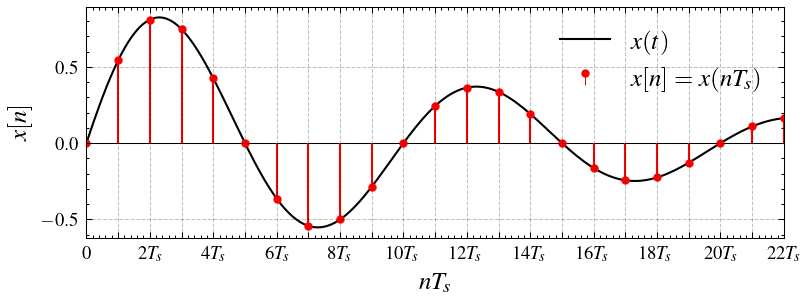

In [5]:
n = np.arange(0, 23)

f = 10
π = np.pi
fs = 100
Ts = 1/fs

xn = np.exp(-8*n*Ts)*np.sin(2*π*f*n*Ts)

t = np.linspace(0, np.max(n)*Ts, 200)
xt = np.exp(-8*t)*np.sin(2*π*f*t)

plt.figure(figsize=(6,2))
plt.hlines(0, 0, np.max(n*Ts))
plt.grid()
ax = plt.gca()
plt.plot(t, xt, label = '$x(t)$' ,linewidth = 1)

base_line = ax.plot(n*Ts, xn,'o')
markerline, stemlines, baseline = plt.stem(n*Ts, xn, base_line[0].get_color(), label = '$x[n] = x(nT_s)$', basefmt=" ")
markerline.set_markersize(3)
stemlines.set_linewidth(1)

# configure tick labels
# Turn off tick labels
ax.set_xticklabels([])
ax.set_xticks(n*Ts)
labels = [item.get_text() for item in ax.get_xticklabels()]

for ind in range(len(labels)):
    if not ind % 2:
        if ind == 0:
            labels[ind] = '$0$'
        elif ind == 1:
            labels[ind] = '$T_s$'
        else:
            labels[ind] = f'${ind}T_s$'
    else:
        labels[ind] = ' '

ax.set_xticklabels(labels)

plt.xlim(np.min(n*Ts),np.max(n*Ts))
plt.xlabel('$nT_s$')
plt.ylabel('$x[n]$')
plt.legend(loc='upper right');

if saveFigures:
    plt.savefig(figurePath + 'discrete_signal.png', dpi=600)

To appropriately represent a continuous-time signal by its discrete-time version, the choice of the sampling rate $f_s$ is crucial. According to the Nyquist-Shannon sampling theorem, the sampling rate should be at least twice the highest frequency component present in the signal to avoid aliasing. If the sampling rate is too low, different frequency components of the signal can become indistinguishable, leading to distortion known as aliasing.

Given the discrete-time samples, the original continuous-time signal can be reconstructed if the sampling rate satisfies the Nyquist criterion and if an appropriate reconstruction filter is used. In practice, the continuous-time signal is often processed by analog-to-digital converters (ADC) to create a digital representation of the discrete-time signal, which can then be used for various digital signal processing applications.

### Discrete-time convolution 

This convolution operation is fundamental in signal processing and systems analysis, as it describes the relationship between input and output of a linear time-invariant (LTI) system. More precisely, given a discrete-time LTI system whose impulse response is given by $h[n]$, let $x[n]$ be the signal applied to the system's input, then the system's output $y[n]$ will be given by the convolution $y[n] = x[n] \ast h[n]$  which is defined as

$$
\begin{align}
y[n] &= (x \ast h)[n] \nonumber \\
     &= \sum_{k=-\infty}^{\infty} x[k] h[n - k] \nonumber\\
     &= \sum_{k=-\infty}^{\infty} h[k] x[n - k]\\
\end{align}
$$

#### Example 2

Suppose we have a discrete-time system whose impulse response $h[n]$ is given by
$$
h[n]= \begin{cases}e^{-0.4n}, & n \leq 0 \\ 0 & \text{otherwise}\end{cases}.
$$

Let $x[n]$ be the discrete-time input to the system, such that
$$
x[n]= \begin{cases}1, & 0\leq n \leq 3 \\ 0 & \text{otherwise}\end{cases}.
$$

Then, the output of the system $y[n]$ is given by

$$
y[n] = (x \ast h)[n] = \begin{cases}\frac{1-e^{-0.4(n+1)}}{1-e^{-0.4}}, & 0\leq n \leq 3 \\ 0 & \text{otherwise}\end{cases}
$$


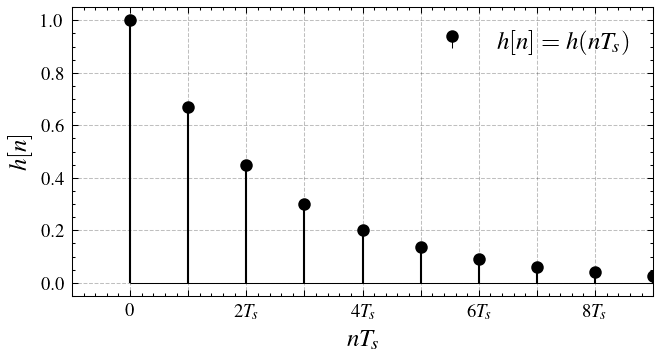

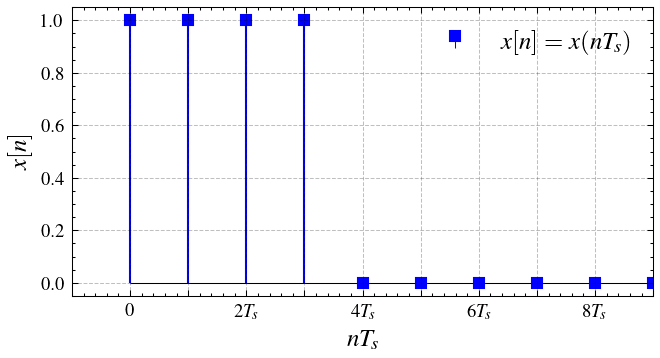

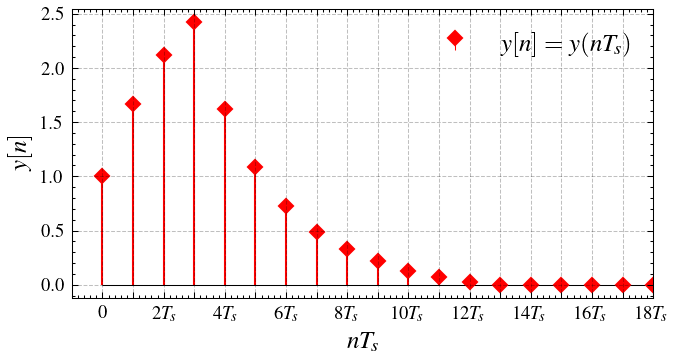

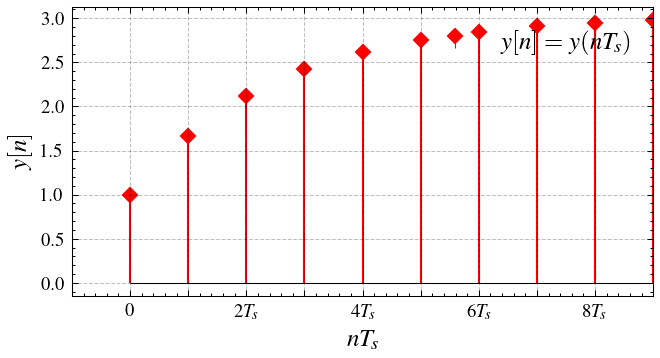

In [12]:
n = np.arange(0, 10)

f = 10
π = np.pi
fs = 100
Ts = 1/fs

xn = np.ones(n.shape)
xn[n>3] = 0

hn = np.exp(-40*n*Ts)

yn = np.convolve(hn, xn)

zn = (1-np.exp(-0.4*(n+1)))/(1-np.exp(-0.4))

for ind, sig in enumerate([hn, xn, yn, zn]):
    if ind == 0:
        case = 'h'
        c = 'k'
        mkfnt = 'o'
    elif ind == 1:
        case = 'x'
        c = 'b'
        mkfnt = 's'
    else:
        case = 'y'
        c = 'r'
        mkfnt = 'D'
        
    n = np.arange(0, len(sig))
    plt.figure(figsize=(5,2.5))
    plt.hlines(0, 0, np.max(n*Ts))
    plt.grid()
    ax = plt.gca()
    base_line = ax.plot(n*Ts, sig,'o')
    markerline, stemlines, baseline = plt.stem(n*Ts, sig, c, markerfmt = mkfnt, label = f'${case}[n] = {case}(nT_s)$', basefmt=" ")
    markerline.set_markersize(5)
    stemlines.set_linewidth(1)


    # configure tick labels
    # Turn off tick labels
    ax.set_xticklabels([])
    ax.set_xticks(n*Ts)
    labels = [item.get_text() for item in ax.get_xticklabels()]

    for ind in range(len(labels)):
        if not ind % 2:
            if ind == 0:
                labels[ind] = '$0$'
            elif ind == 1:
                labels[ind] = '$T_s$'
            else:
                labels[ind] = f'${ind}T_s$'
        else:
            labels[ind] = ' '

    ax.set_xticklabels(labels)

    plt.xlim(np.min(n*Ts)-Ts,np.max(n*Ts))
    plt.xlabel('$nT_s$')
    plt.ylabel(f'${case}[n]$')
    plt.legend(loc='upper right');

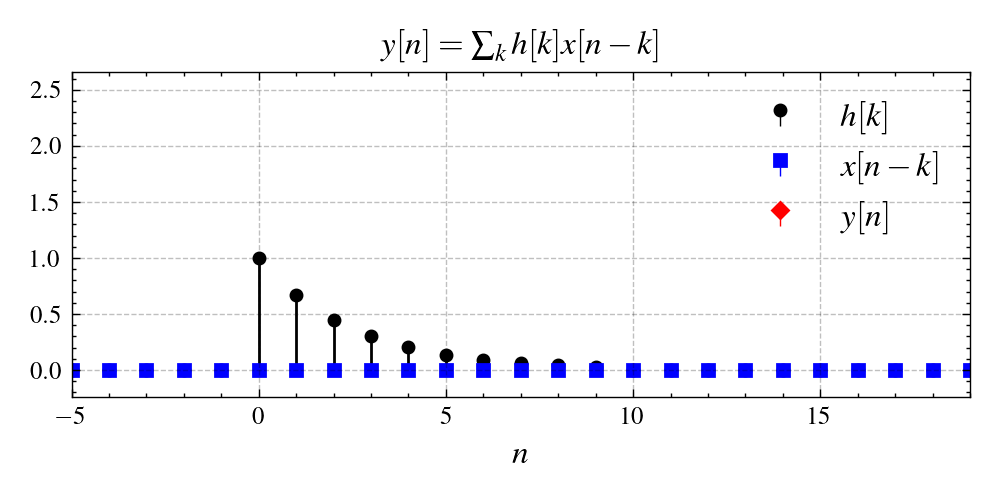

In [7]:
nStart = -5
nEnd = 20
figName = "conv_animation.gif"
xlabel = "$n$"
ylabel = ["$x[n-k]$", "$h[k]$", "$y[n]$"]
inter = 800
plotConv = True

figName  = './convolutionFig1.gif'
genConvGIF(xn, hn, nStart, nEnd, figName, xlabel, ylabel, inter)

Image('./convolutionFig1.gif', width=800)

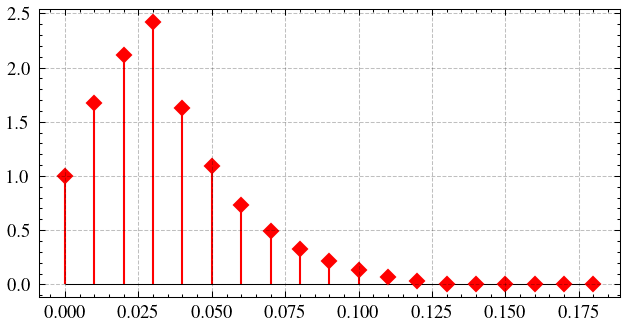

In [8]:
n = np.arange(0, len(sig))
plt.figure(figsize=(5,2.5))
plt.hlines(0, 0, np.max(n*Ts))
plt.grid()
ax = plt.gca()
base_line = ax.plot(n*Ts, sig,'o')
markerline, stemlines, baseline = plt.stem(n*Ts, sig, c, markerfmt = mkfnt, label = f'${case}[n] = {case}(nT_s)$', basefmt=" ")
markerline.set_markersize(5)
stemlines.set_linewidth(1)

### The Z-transform

The Z-transform is mathematical transform applied in the analysis and design of discrete-time signals and systems. It provides a way to represent discrete-time signals in the complex frequency domain, which is useful for e.g. solving linear difference equations, analyzing system stability, and performing signal processing tasks.

**Definition**: given a discrete-time signal $x[n]$, the Z-transform is defined as

$$
\begin{equation}
X(z) = \mathcal{Z}\left\lbrace x[n]\right\rbrace = \sum_{n=-\infty}^{\infty} x[n] z^{-n}
\end{equation}
$$

where $X(z)$ is the Z-transform of $x[n]$, $z$ is a complex variable, $z = re^{j\theta}$, where $r$ is the magnitude and $\theta$ is the angle in radians. The summation of the Z-transform converges only for certain values of $z$. The set of all $z$ for which the series converges is called the Region of Convergence (ROC).

The original discrete-time signal $x[n]$ can be recovered from its Z-transform $X(z)$ using the inverse Z-transform. If $X(z)$ is known, the inverse Z-transform is given by:

$$
\begin{equation}
x[n] = \mathcal{Z}^{-1}\left\lbrace X(z)\right\rbrace = \frac{1}{2\pi j} \oint_{C} X(z) z^{n-1} , dz
\end{equation}
$$

where the contour $C$ is a closed path within the ROC.

The Z-transform possess several properties that are important in digital signal processing applications. One of the most important properties is that the convolution of two sequences in the time domain corresponds to multiplication in the z-domain, i.e. if $y[n] = x[n] * h[n]$, then
$$
\begin{equation}
Y(z) = X(z) H(z)
\end{equation}
$$

### The discrete-time Fourier transform (DTFT)

The discrete-time Fourier transform (DTFT) is a mathematical transformation used to obtain frequency domain representations of discrete-time signals.

**Definition**: given a discrete-time signal $x[n]$, the DTFT is defined as

$$
\begin{equation}
X(\hat{f}) = \sum_{n=-\infty}^{\infty} x[n] e^{-j 2 \pi \hat{f} n}
\end{equation}
$$

where $\hat{f} = \frac{f}{f_s}$ is the normalized frequency, which is a continuous variable in the range $-1/2 \leq \hat{f} \leq 1/2$. 

Note that $X(\hat{f})$ is the Z-transform $X(z)$ of $x[n]$ evaluated at $z=e^{j 2 \pi \hat{f}}$.

The original discrete-time signal $x[n]$ can be recovered from its DTFT $X(\hat{f})$ using the inverse DTFT, defined as

$$
\begin{equation}
x[n] = \int_{-1/2}^{1/2} X(\hat{f}) e^{j 2 \pi \hat{f}  n} \, d\hat{f}.
\end{equation}
$$

Among several other important properties of the DTFT, as for the Z-transform, the convolution of two discrete-time signals corresponds to the multiplication of their DTFTs, i.e. If $y[n] = h[n] * x[n]$, then
$$
\begin{equation}
Y(\hat{f}) = H(\hat{f}) X(\hat{f})
\end{equation}
$$
and total energy of the signal in the time domain is equal to the total energy in the frequency domain
$$
\begin{equation}
\sum_{n=-\infty}^{\infty} |x[n]|^2 = \int_{-1/2}^{1/2} |X(\hat{f})|^2 \, d\hat{f}
\end{equation}
$$
which is known as Parseval's relation.

### The discrete Fourier transform (DFT)

The discrete Fourier transform (DFT) is transformation that converts a finite sequence of equally spaced samples of a function (in the time domain) into a sequence of equally spaced samples of the DTFT (in the frequency domain). As the DTFT, the DFT is can be used for analyzing the frequency content of discrete-time signals.

**Definition**: given a sequence $x[n]$ of length $N$, the DFT is defined as
$$
\begin{equation}
X[k] = \sum_{n=0}^{N-1} x[n] e^{-j \frac{2\pi}{N} kn} \quad \text{for } k = 0, 1, 2, \ldots, N-1
\end{equation}
$$
where $X[k]$ is the $k$-th element of the DFT.

The inverse DFT (IDFT) is used to convert the frequency-domain sequence back into the time-domain sequence
$$
\begin{equation}
x[n] = \frac{1}{N} \sum_{k=0}^{N-1} X[k] e^{j \frac{2\pi}{N} kn} \quad \text{for } n = 0, 1, 2, \ldots, N-1
\end{equation}
$$
The DFT plays a determinant role in several digital signal processing applications mostly due its Fast Fourier Transform (FFT) algorithmic implementations. The FFT is an efficient algorithm to compute the DFT and its inverse. The FFT reduces the computational complexity of the DFT from $O(N^2)$ to $O(N \log N)$, making it feasible to compute the DFT for large sequences.

#### Relationship Between DFT and DTFT

The DFT and the DTFT are both used to analyze discrete-time signals in the frequency domain, but they have different properties and applications. 

**Sampling in Frequency**: the DFT samples the DTFT at $N$ equally spaced points in the frequency domain. Specifically, the DFT samples the DTFT at frequencies $f_k = \frac{k}{N}$.

**Periodicity**: the DTFT of a finite-length sequence is periodic with period $1$, and the DFT captures one period of this periodic spectrum.

#### Convolution Properties of DFT

The DFT has several important properties related to convolution:

**Circular Convolution**: when convolving two sequences using the DFT, the result is a circular convolution rather than a linear convolution. Given two sequences $x[n]$ and $h[n]$, their circular convolution is defined as:

$$
\begin{equation}
y[n] = (x \circ h)[n] = \sum_{m=0}^{N-1} x[m] h[(n - m) \mod N]
\end{equation}
$$

**Linear Convolution Using DFT**: linear convolution can be computed using the DFT by zero-padding the sequences to length $N \geq L + M - 1$, where $L$ and $M$ are the lengths of the original sequences. The steps are:

1. Zero-pad the sequences $x[n]$ and $h[n]$ to length $N$.
2. Compute the DFTs: $X[k] = \text{DFT}(x[n])$ and $H[k] = \text{DFT}(h[n])$.
3. Multiply the DFTs: $Y[k] = X[k] \cdot H[k]$.
4. Compute the inverse DFT: $y[n] = \text{IDFT}(Y[k])$.

This process gives the linear convolution of the original sequences.